In [8]:
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import os
import re
import torch
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p data
!cp drive/MyDrive/samolet/train_dataset_Самолет.csv data

def seed_everything(seed=7575):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Подгружаем и размечаем данные

In [30]:
import numpy as np
import pandas as pd


def split_data(data, id_col='client_id', data_col='report_date', target_col='target', oos_rate=0.15, oot_date='2023-02-01', seed=7575):
  # OOT split
  data.loc[data[data_col] == oot_date, 'test_flag'] = 'oot'
  train_oos_client_id_set = set(data[data['test_flag'] != 'oot'][id_col].unique())
  data.loc[(data['test_flag'] == 'oot') & (~data[id_col].isin(train_oos_client_id_set)), 'test_flag'] = 'oot_full'

  # OOS split
  rng = np.random.default_rng(seed=seed)
  train_oos = data[~data['test_flag'].isin(['oot', 'oot_full'])]
  train_oos_target0_client_id_list = sorted(list(train_oos[train_oos[target_col] == 0][id_col].unique()))
  train_oos_target1_client_id_list = sorted(list(train_oos[train_oos[target_col] == 1][id_col].unique()))

  oos_count = round(len(train_oos_client_id_set) * oos_rate)
  train_oos_bad_rate = train_oos['target'].sum() / train_oos.shape[0]

  oos_target0_client_id_list = rng.choice(train_oos_target0_client_id_list, round(oos_count * (1-train_oos_bad_rate)))
  oos_target1_client_id_list = rng.choice(train_oos_target1_client_id_list, round(oos_count * train_oos_bad_rate))

  data.loc[data[id_col].isin(oos_target0_client_id_list), 'test_flag'] = 'oos'
  data.loc[data[id_col].isin(oos_target1_client_id_list), 'test_flag'] = 'oos'
  data.loc[~data['test_flag'].isin(['oos', 'oot', 'oot_full']), 'test_flag'] = 'train'
  return data

data = pd.read_csv('data/train_dataset_Самолет.csv')
data = split_data(data, id_col='client_id', data_col='report_date', target_col='target', oos_rate=0.15, oot_date='2023-02-01', seed=7575)

train = data[data['test_flag'] == 'train'].drop(columns=['test_flag'])
oos = data[data['test_flag'] == 'oos'].drop(columns=['test_flag'])
oot = data[data['test_flag'] == 'oot'].drop(columns=['test_flag'])

print(f"Train shape: {train.shape}")
print(f"OOS shape: {oos.shape}")
print(f"OOT shape: {oot.shape}")
print(f"Train bad rate: {round((train['target'].sum() / train.shape[0]) * 100, 2)}%")
print(f"OOS bad rate: {round((oos['target'].sum() / oos.shape[0]) * 100, 2)}%")
print(f"OOT bad rate: {round((oot['target'].sum() / oot.shape[0]) * 100, 2)}%")

Train shape: (11483, 2666)
OOS shape: (1960, 2666)
OOT shape: (747, 2666)
Train bad rate: 2.95%
OOS bad rate: 4.18%
OOT bad rate: 1.87%


In [24]:
id_cols = ['test_flag', 'report_date', 'target', 'client_id']

## Categorical features

In [32]:
data['client_id'] = data['client_id'].astype(str)
df_categorical = data.select_dtypes(exclude=[np.number])
data['client_id'] = data['client_id'].astype(int)
data_category = data[df_categorical.columns.tolist() + ['target']].copy()

### Binary links features

In [26]:
def contains_link(text):
    return bool(re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))

# Создайте список признаков, в которых есть ссылка
columns_with_links = [col for col in data_category.columns if data_category[col].astype(str).apply(contains_link).any()]

print("Признаки, в которых встречается ссылка:")
print(columns_with_links)
print(f"Их количество: {len(columns_with_links)}")

Признаки, в которых встречается ссылка:
['col49', 'col50', 'col51', 'col52', 'col53', 'col54', 'col55', 'col56', 'col221', 'col222', 'col223', 'col224', 'col225', 'col226', 'col227', 'col228', 'col237', 'col238', 'col239', 'col240', 'col241', 'col242', 'col243', 'col244', 'col457', 'col458', 'col459', 'col460', 'col461', 'col462', 'col463', 'col464', 'col551', 'col553', 'col554', 'col555', 'col556', 'col557', 'col558', 'col559', 'col560', 'col1046', 'col1047', 'col1048', 'col1049', 'col1050', 'col1051', 'col1052']
Их количество: 48


In [33]:
cols_samolet = [
    'col49', # 5 ссылок на  самолет
    'col50', # 10 ссылок на  самолет
    'col51', # 20 ссылок на  самолет
    'col52', # 107 ссылок на  самолет
    'col53', # 5 ссылок на  самолет
    'col54', # 10 ссылок на  самолет
    'col55', # 20 ссылок на  самолет
    'col56', # 120 ссылок на  самолет
    'col221', # 20 ссылок на  самолет
    'col222', # 141 ссылок на  самолет
    'col223', # 270 ссылок на  самолет
    'col224', # 556 ссылок на  самолет
    'col225', # 175 ссылок на  самолет
    'col226', # 307 ссылок на  самолет
    'col227', # 478 ссылок на  самолет
    'col228', # 809 ссылок на  самолет
]

col_parking = [
    'col237', # 10 ссылок на паркинг
    'col238', # 30 ссылок на паркинг
    'col239', # 64 ссылок на паркинг
    'col240', # 148 ссылок на паркинг
    'col241', # 20 ссылок на паркинг
    'col242', # 62 ссылок на паркинг
    'col243', # 99 ссылок на паркинг
    'col244', # 190 ссылок на паркинг
]

cols_flats = [
    'col457', # 50 ссылок на квартиры
    'col458', # 124 ссылок на квартиры
    'col459', # 238 ссылок на квартиры
    'col460', # 589 ссылок на квартиры
    'col461', # 211 ссылок на квартиры
    'col462', # 363 ссылок на квартиры
    'col463', # 545 ссылок на квартиры
    'col464', # 891 ссылок на квартиры
]

cols_dir = [ # какие то переходы в директории
    'col551', # 1108 ссылок
    'col552', # 1577 ссылок
    'col1046', # 40 ссылок
    'col1047', # 107 ссылок
    'col1048', # 250 ссылок
    'col1049', # 40 ссылок
    'col1050', # 126 ссылок
    'col1051', # 231 ссылок
    'col1052', # 481 ссылок
]

cols_random = [ #какие то рандомные ссылки в том числе самолет
    'col553', # 63 ссылок
    'col554', # 139 ссылок
    'col555', # 286 ссылок
    'col556', # 571 ссылок
    'col557', # 430 ссылок
    'col558', # 626 ссылок
    'col559', # 908 ссылок
    'col560', # 1308 ссылок
]

cols_leak = [
    'col1454'
]

data_category["parking"]=data_category[col_parking].fillna(value='0').apply(lambda row: 0 if all(value == "0" for value in row) else 1, axis=1)
data_category["samolet"]=data_category[cols_samolet].fillna(value='0').apply(lambda row: 0 if all(value == "0" for value in row) else 1, axis=1)
data_category["flats"]=data_category[cols_flats].fillna(value='0').apply(lambda row: 0 if all(value == "0" for value in row) else 1, axis=1)
data_category["dir"]=data_category[cols_dir].fillna(value='0').apply(lambda row: 0 if all(value == "0" for value in row) else 1, axis=1)

### Drop low fullness features

In [34]:
def drop_fullness_cols(data, num=60):
  num_cols_before = data.shape[1]
  fullness_count = data.notna().sum(axis=0)
  data = data[(fullness_count[fullness_count >= num]).index]
  num_cols_after = data.shape[1]
  print(f"Droped cols: {num_cols_before - num_cols_after}")
  return data

data_category = drop_fullness_cols(data_category, num=60)

Droped cols: 128


### Concat features groups

In [35]:
df_tmp = data_category[[col for col in data_category.columns if col not in id_cols+['parking', 'samolet', 'flats', 'dir']]]
agg_cols_dict = dict()
orig_col = df_tmp.columns[0]
for i in tqdm(range(1, len(df_tmp.columns))):
  notna_mask = df_tmp[df_tmp.columns[i-1]].notna()
  if ((df_tmp.loc[notna_mask, orig_col].fillna(-1) == df_tmp.loc[notna_mask, df_tmp.columns[i]].fillna(-1)).sum() / notna_mask.sum()) > 0.4:
    agg_cols_dict[orig_col] = agg_cols_dict.get(orig_col, list()) + [df_tmp.columns[i-1]]
  else:
    orig_col = df_tmp.columns[i]

for col in tqdm(agg_cols_dict.keys()):
  data_category[col] = data_category[agg_cols_dict[col]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_category = data_category[id_cols+['parking', 'samolet', 'flats', 'dir']+list(agg_cols_dict.keys())]

100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


In [36]:
categorical_features_list = [col for col in data_category.columns if col not in id_cols+cols_samolet+cols_leak+col_parking+cols_flats+cols_dir+cols_random]

## Numerical features

In [12]:
from tqdm import tqdm

def do_num_feat(data_new):

    num_columns = []
    for col in tqdm(data_new.columns):
        try:
            data_new[col] = data_new[col].astype(float)
        except:
            continue
        num_columns.append(col)

    cols1 = []
    cols2 = []
    cols3 = []
    cols4 = []
    cols5 = []
    cols6 = []
    cols7 = []
    cols8 = []
    other = []

    for col in tqdm(num_columns[2:]):
        tmp = np.mean(data_new[col].astype(float).dropna().unique())
        if tmp < 0:
            cols1.append(col)
        elif tmp >= 0 and tmp <= 1:
            cols2.append(col)
        elif tmp > 1 and tmp <= 3:
            cols3.append(col)
        elif tmp > 3 and tmp < 15:
            cols4.append(col)
        elif tmp >= 15 and tmp < 1000:
            cols5.append(col)
        elif tmp >= 1000 and tmp < 10000:
            cols6.append(col)
        elif tmp >= 10000 and tmp < 1000000:
            cols7.append(col)
        elif tmp >= 1000000:
            cols8.append(col)
        else:
            other.append(col)

    for i, cols in enumerate([cols1, cols2, cols3, cols4, cols5, cols6, cols7, cols8]):
        tmp = data_new[["client_id","report_date"] + cols].copy()
        tmp = tmp.dropna(how='all', subset=cols)
        tmp['mean_group_' + str(i+1)] = tmp[cols].mean(axis=1)
        tmp['max_group_' + str(i+1)] = tmp[cols].max(axis=1)
        tmp['min_group_' + str(i+1)] = tmp[cols].min(axis=1)
        tmp = tmp.drop(cols, axis=1)
        data_new = data_new.merge(tmp, on=["client_id","report_date"], how='left')
    return data_new

def do_target_before(dataset):
    one_unique = dataset[dataset.target == 1].client_id.unique()
    data1 = dataset[dataset.client_id.isin(one_unique)][["report_date", "client_id", "target"]].sort_values(by=["client_id", "report_date"])
    data1["target_before"] = 0.0
    for idx in tqdm(one_unique):
        index_cl = data1[data1.client_id==idx].index.to_list()
        data1.loc[index_cl, "target_before"] = data1[data1.client_id==idx].target.shift(1).values
    data_new = dataset.merge(data1[["report_date", "client_id", "target_before"]], on=["report_date", "client_id"], how='left')
    print(data_new.shape)
    data_new.target_before = data_new.target_before.fillna(0)
    return data_new

def do_count_befor(dataset):
    dataf = dataset[["report_date","client_id","target"]].sort_values(by=["report_date"])
    dataf['count_befor'] = 0
    dict_id = dict()
    for i in range(dataf.shape[0]):
        id_tmp = dataf.iloc[i, 1]
        if dict_id.get(id_tmp) is None:
            dict_id[id_tmp] = 1
        else:
            dict_id[id_tmp] += 1
        dataf.iloc[i, 3] = dict_id[id_tmp]
    dataset = dataset.merge(dataf[["report_date", "client_id", "count_befor"]], on=["report_date", "client_id"], how='left')
    return dataset

def fill_id_na(dataset):

    data_sort = dataset.sort_values(by=['client_id', 'report_date'])
    data_sort.index = range(data_sort.shape[0])
    freq_id = data_sort.client_id.value_counts()[data_sort.client_id.value_counts() > 1].index.to_list()
    data_sort_np = data_sort.to_numpy()

    idx_list = []
    for idn in tqdm(freq_id):
        idx_list.append(data_sort[data_sort.client_id==idn].index.to_list())

    for idx in tqdm(idx_list):
        for i in range(1, len(idx)):
            np.putmask(data_sort_np[idx[i], :], pd.isnull(data_sort_np[idx[i], :]), data_sort_np[idx[i-1], :])

    data_s = pd.DataFrame(data_sort_np, columns=data_sort.columns)
    return data_s

In [14]:
data_numerical = pd.read_csv("data/train_dataset_Самолет.csv", low_memory=False)
data_numerical = do_target_before(data_numerical)
data_numerical = do_count_befor(data_numerical)
data_numerical = fill_id_na(data_numerical)
data_numerical = do_num_feat(data_numerical)

100%|██████████| 183/183 [00:00<00:00, 460.95it/s]


(14456, 2667)


100%|██████████| 2315/2315 [00:01<00:00, 2026.03it/s]


## Concat features

In [37]:
#data_numerical_backup = data_numerical.copy()
#data_category_backup = data_category.copy()

In [ ]:
#anton_split = pd.read_csv("samolet_dataset.csv", low_memory=False)

In [17]:
numerical_features_list = ['mean_group_1', 'max_group_1',
       'min_group_1', 'mean_group_2', 'max_group_2', 'min_group_2',
       'mean_group_3', 'max_group_3', 'min_group_3', 'mean_group_4',
       'max_group_4', 'min_group_4', 'mean_group_5', 'max_group_5',
       'min_group_5', 'mean_group_6', 'max_group_6', 'min_group_6',
       'mean_group_7', 'max_group_7', 'min_group_7', 'mean_group_8',
       'max_group_8', 'min_group_8','count_befor',
       'target_before']

In [39]:
data_numerical = data_numerical[["report_date", "client_id"]+numerical_features_list].merge(data_category, on=["report_date", "client_id"], how='left')

In [40]:
train = data_numerical[data_numerical.test_flag=='train']
oot = data_numerical[data_numerical.test_flag=='oot']
oos = data_numerical[data_numerical.test_flag=='oos']

In [43]:
features_list = numerical_features_list + categorical_features_list

In [44]:
!pip install catboost
from catboost import CatBoostClassifier, Pool, cv

    #  обучение

params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "verbose": 50,
#     'learning_rate': 0.005,
    "od_type": "Iter",
    "od_wait": 100,
    "iterations": 200,
}

id_cols = ['report_date', 'client_id', 'target']

train_pool = Pool(train[features_list], train['target'], cat_features=categorical_features_list)
val_pool = Pool(oos[features_list], oos['target'], cat_features=categorical_features_list)

model = CatBoostClassifier(**params, random_state=7575)
model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.116626
0:	test: 0.8517137	best: 0.8517137 (0)	total: 252ms	remaining: 50.1s
50:	test: 0.8971369	best: 0.9036793 (19)	total: 6.67s	remaining: 19.5s
100:	test: 0.8966142	best: 0.9036793 (19)	total: 15.1s	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9036793163
bestIteration = 19

Shrink model to first 20 iterations.


In [46]:
from sklearn.metrics import classification_report

preds = model.predict_proba(val_pool)
preds = [1 if val >= 0.5 else 0 for val in preds[:, 1]]
print("\033[1m OOS \033[0m")
print(classification_report(oos['target'].astype(int), preds))
print()

oot_pool = Pool(oot[features_list], oot['target'], cat_features=categorical_features_list)
preds = model.predict_proba(oot_pool)
preds = [1 if val >= 0.5 else 0 for val in preds[:, 1]]
print("\033[1m OOT \033[0m")
print(classification_report(oot['target'].astype(int), preds))

 OOS 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1878
           1       1.00      0.59      0.74        82

    accuracy                           0.98      1960
   macro avg       0.99      0.79      0.86      1960
weighted avg       0.98      0.98      0.98      1960


 OOT 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       733
           1       1.00      0.71      0.83        14

    accuracy                           0.99       747
   macro avg       1.00      0.86      0.92       747
weighted avg       0.99      0.99      0.99       747



Text(0.5, 1.0, 'Feature Importance')

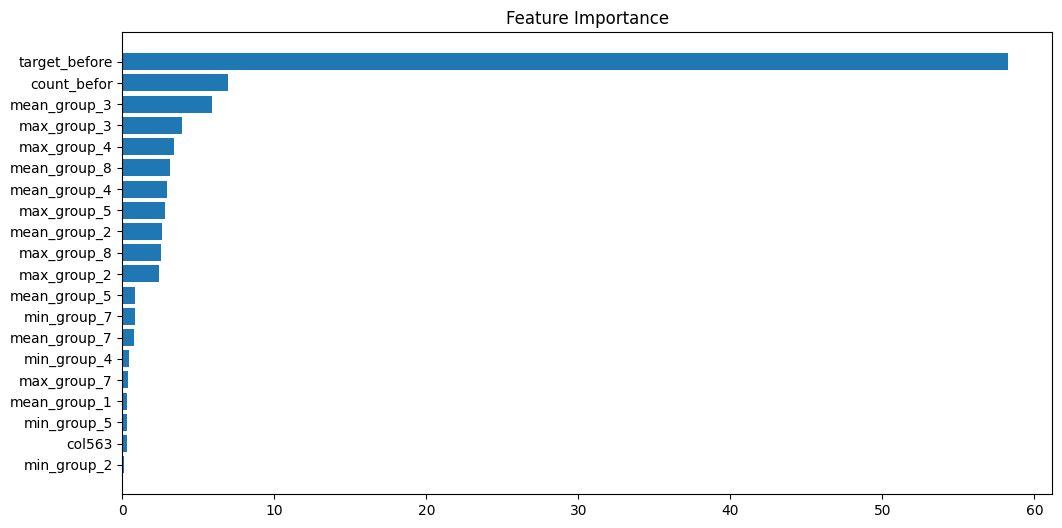

In [49]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_list)[sorted_idx])
plt.title('Feature Importance')